# Corridor

In [1]:
import sys, os;

module_path = os.path.abspath(os.path.join('../../..'))

if module_path not in sys.path:
    print(f"Adding [{module_path}] to sys.path")
    sys.path.append(module_path)

Adding [/home/arc/Projects/pwr/pyalcs-experiments] to sys.path


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator 

from pylab import cm
import pathlib

from lcs import Perception

import gym
import gym_corridor

# Logger
# import logging
# logging.basicConfig(level=logging.DEBUG)

In [3]:
from notebooks import get_from_cache_or_run

# Import utils functions
%run utils/experiments.py
%run utils/metrics.py
%run utils/plots.py
%run utils/payoff_landscape.py
%run utils/basic_rl.py

In [4]:
# Plot settings
mpl.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 2

# Common color palette
palette = cm.get_cmap('Paired', 5)

COLORS = {
    'ACS2': palette(0),
    'AACS2_v1': palette(1),
    'AACS2_v2': palette(2),
    'Q-Learning': palette(3),
    'R-Learning': palette(4)
}

## Environment setup

In [5]:
class CorridorObservationWrapper(gym.ObservationWrapper):
    def observation(self, observation):
        return observation,

In [6]:
env = CorridorObservationWrapper(gym.make('corridor-20-v0'))
env.reset()

('4',)

In [7]:
cache_prefix = f'{pathlib.Path().absolute()}/cache/{env.unwrapped.__class__.__name__}'
cache_prefix

'/home/arc/Projects/pwr/pyalcs-experiments/notebooks/publications/anticipatory-classifier-system-with-average-reward-criterion-in-discretized-multi-step-environments/cache/Corridor'

## Basic Metrics
Examine population size, rho parameter and exploitation capabilities.

In [8]:
# Params
learning_rate = 0.8
discount_factor = 0.95
epsilon = 0.2
zeta = 0.0001

# Set ACS2/AACS2 configuration parameter dictionary
basic_cfg = {
    'perception_bits': 1,
    'possible_actions': 2,
    'do_ga': False,
    'beta': learning_rate,
    'epsilon': epsilon,
    'gamma': discount_factor,
    'zeta': zeta,
    'user_metrics_collector_fcn': common_metrics,
    'biased_exploration_prob': 0,
    'metrics_trial_freq': 1
}

trials = 10_000
experiments = 5

In [9]:
%%time

p_acs2, p_aacs2v1, p_aacs2v2, agg_df = get_from_cache_or_run(
    f'{cache_prefix}/{trials}-trials-over-{experiments}-exp.dill',
    lambda: avg_experiments(experiments, fun=lambda: run_experiments_alternating(trials=trials, env=env, params=basic_cfg)))

Experiment: 100%|██████████| 5/5 [03:30<00:00, 42.18s/it]

CPU times: user 3min 30s, sys: 117 ms, total: 3min 31s
Wall time: 3min 31s


In [10]:
%%time

init_Q = np.zeros((env.observation_space.n, env.action_space.n))

q_learning_metrics = get_from_cache_or_run(
    f'{cache_prefix}/{trials}-qlearning-trials-over-{experiments}-exp.dill',
    lambda: run_q_learning_alternating(experiments, trials, env, epsilon, learning_rate, discount_factor, init_Q, perception_to_state_mapper=lambda p: int(p[0]))
)

100%|██████████| 5/5 [00:29<00:00,  5.86s/it]


CPU times: user 31 s, sys: 605 ms, total: 31.6 s
Wall time: 30.9 s


In [11]:
%%time

init_R = np.zeros((env.observation_space.n, env.action_space.n))

r_learning_metrics = get_from_cache_or_run(
    f'{cache_prefix}/{trials}-rlearning-trials-over-{experiments}-exp.dill',
    lambda: run_r_learning_alternating(experiments, trials, env, epsilon, learning_rate, zeta, init_R, perception_to_state_mapper=lambda p: int(p[0]))
)

100%|██████████| 5/5 [00:17<00:00,  3.41s/it]


CPU times: user 19.6 s, sys: 824 ms, total: 20.5 s
Wall time: 19.4 s


In [12]:
agg_df = pd.concat([
    agg_df,
    pd.DataFrame(q_learning_metrics).groupby(['agent', 'trial', 'phase']).mean().reset_index(level='phase'),
    pd.DataFrame(r_learning_metrics).groupby(['agent', 'trial', 'phase']).mean().reset_index(level='phase')]
)

agg_df

phase  steps_in_trial        rho  population  reliable
agent      trial                                                          
AACS2_v1   0      explore           169.6   0.000000        17.4      13.6
           1      exploit            82.8   0.000000        17.4      13.6
           2      explore           140.2   0.020000        24.4      18.2
           3      exploit            98.6   0.020000        24.4      18.2
           4      explore           129.2   0.059936        28.8      22.2
...                   ...             ...        ...         ...       ...
R-Learning 9995   exploit             6.4  89.819927         NaN       NaN
           9996   explore            14.8  89.787261         NaN       NaN
           9997   exploit             8.2  89.813656         NaN       NaN
           9998   explore            12.4  89.802342         NaN       NaN
           9999   exploit             7.0  89.839688         NaN       NaN

[50000 rows x 5 columns]

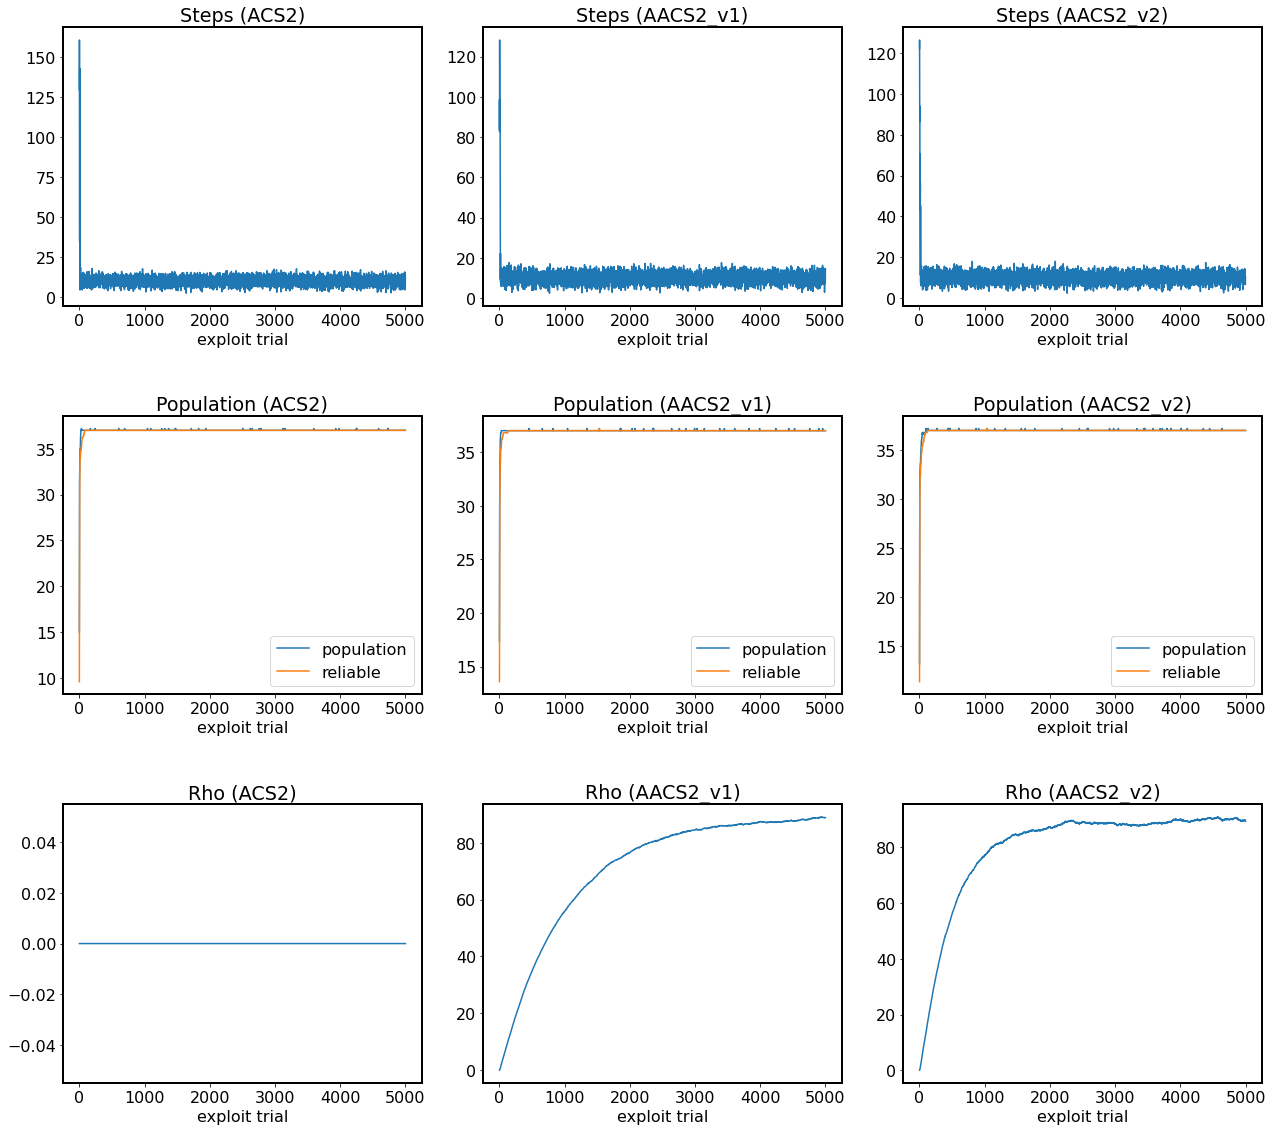

In [13]:
plot_exploit_results(agg_df)

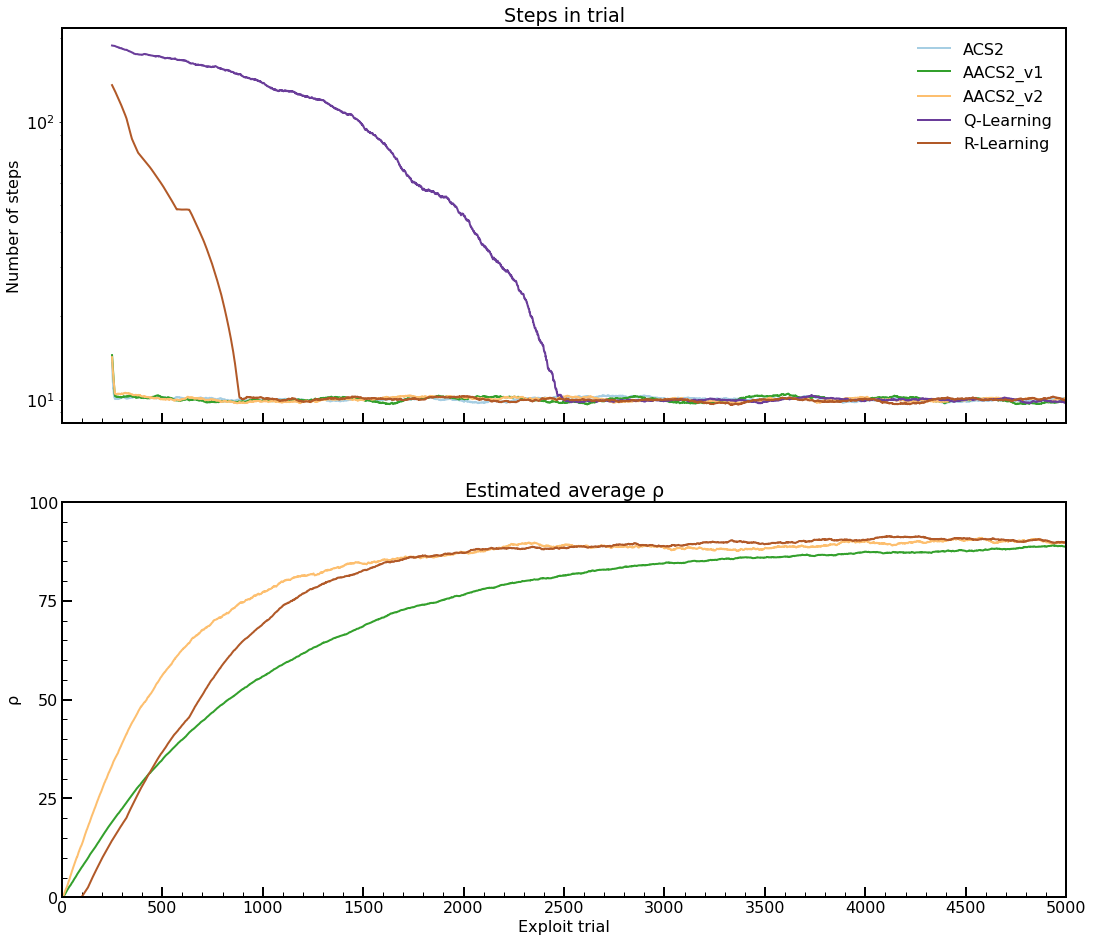

In [14]:
def plot_pop_and_rho(df):
    expl_df = df[df['phase'] == 'exploit']
    
    fig, axs = plt.subplots(2, 1, figsize=(18, 16), sharex=True)
    xmax = trials/2
    
    # Steps in trial plot
    for alg in ['ACS2', 'AACS2_v1', 'AACS2_v2', 'Q-Learning', 'R-Learning']:
        alg_df = expl_df.loc[alg]
        idx = pd.Index(name='exploit trial', data=np.arange(1, len(alg_df) + 1))
        alg_df.set_index(idx, inplace=True)
        
        alg_df['steps_in_trial'].rolling(window=250).mean().plot(ax=axs[0], label=alg, linewidth=2, color=COLORS[alg])
    
    axs[0].set_xlim(0, xmax)
    axs[0].set_xlabel("Exploit trial")
    axs[0].xaxis.set_major_locator(MultipleLocator(500))
    axs[0].xaxis.set_minor_locator(MultipleLocator(100))
    axs[0].xaxis.set_major_formatter(FormatStrFormatter('%1.0f')) 
    axs[0].xaxis.set_tick_params(which='major', size=10, width=2, direction='in')
    axs[0].xaxis.set_tick_params(which='minor', size=5, width=1, direction='in')
    
    axs[0].set_ylabel("Number of steps")
    axs[0].set_yscale('log')
#     axs[0].yaxis.set_major_locator(MultipleLocator(20))
#     axs[0].yaxis.set_minor_locator(MultipleLocator(5))
#     axs[0].yaxis.set_tick_params(which='major', size=10, width=2, direction='in')
#     axs[0].yaxis.set_tick_params(which='minor', size=5, width=1, direction='in')
    
    axs[0].set_title('Steps in trial')
    axs[0].legend(loc='upper right', frameon=False)
    
    # Rho plot
    for alg in ['AACS2_v1', 'AACS2_v2', 'R-Learning']:
        alg_df = expl_df.loc[alg]
        idx = pd.Index(name='exploit trial', data=np.arange(1, len(alg_df) + 1))
        alg_df.set_index(idx, inplace=True)
        
        alg_df['rho'].rolling(window=1).mean().plot(ax=axs[1], label=alg, linewidth=2, color=COLORS[alg])
        
    axs[1].set_xlim(0, xmax)
    axs[1].set_xlabel("Exploit trial")
    axs[1].xaxis.set_major_locator(MultipleLocator(500))
    axs[1].xaxis.set_minor_locator(MultipleLocator(100))
    axs[1].xaxis.set_major_formatter(FormatStrFormatter('%1.0f')) 
    axs[1].xaxis.set_tick_params(which='major', size=10, width=2, direction='in')
    axs[1].xaxis.set_tick_params(which='minor', size=5, width=1, direction='in')
    
    axs[1].set_ylabel(r"$\mathregular{\rho}$")
    axs[1].yaxis.set_major_locator(MultipleLocator(25))
    axs[1].yaxis.set_minor_locator(MultipleLocator(5))
    axs[1].yaxis.set_tick_params(which='major', size=10, width=2, direction='in')
    axs[1].yaxis.set_tick_params(which='minor', size=5, width=1, direction='in')
    axs[1].set_ylim(0, 100)
    
    axs[1].set_title(r'Estimated average $\mathregular{\rho}$')
#     axs[1].legend(loc='lower right', frameon=False)
    
    # plt.savefig('plots/corridor-steps_rho.pdf', transparent=False, bbox_inches='tight')
    
    
plot_pop_and_rho(agg_df)

## Payoff Landscape

In [15]:
state_action = get_all_state_action(env.unwrapped._state_action())
print(len(state_action))
state_action[:10]

38


[StateAction(id=1, state='0', action=0),
 StateAction(id=2, state='0', action=1),
 StateAction(id=3, state='1', action=0),
 StateAction(id=4, state='1', action=1),
 StateAction(id=5, state='2', action=0),
 StateAction(id=6, state='2', action=1),
 StateAction(id=7, state='3', action=0),
 StateAction(id=8, state='3', action=1),
 StateAction(id=9, state='4', action=0),
 StateAction(id=10, state='4', action=1)]

### Data preparation

In [16]:
# Take first of each algorithm pass population for presenting payoff landscape 
pop_acs2 = p_acs2[0]
pop_aacs2v1 = p_aacs2v1[0]
pop_aacs2v2 = p_aacs2v2[0]

#### Q-learning

In [17]:
%%time

Q_init = np.zeros((env.observation_space.n, env.action_space.n))
Q, _ = qlearning(env, trials, Q_init, epsilon, learning_rate, discount_factor, perception_to_state_mapper=lambda p: int(p[0]))

Q-Learning: 100%|██████████| 10000/10000 [00:04<00:00, 2087.10it/s]

CPU times: user 4.99 s, sys: 668 ms, total: 5.66 s
Wall time: 4.79 s


#### R-learning

In [18]:
%%time

R_init = np.zeros((env.observation_space.n, env.action_space.n))
R, rho, _ = rlearning(env, trials, R_init, epsilon, learning_rate, zeta, perception_to_state_mapper=lambda p: int(p[0]))

R-Learning: 100%|██████████| 10000/10000 [00:03<00:00, 3332.30it/s]

CPU times: user 3.16 s, sys: 335 ms, total: 3.49 s
Wall time: 3 s


In [19]:
rho

80.5003187162037

### Landscape plot

In [20]:
payoffs = {}

for sa in state_action:
    p = Perception((sa.state,))

    # ACS2
    acs2_match_set = pop_acs2.form_match_set(p)
    acs2_action_set = acs2_match_set.form_action_set(sa.action)

    # AACS2_v1
    aacs2v1_match_set = pop_aacs2v1.form_match_set(p)
    aacs2v1_action_set = aacs2v1_match_set.form_action_set(sa.action)

    # AACS2_v2
    aacs2v2_match_set = pop_aacs2v2.form_match_set(p)
    aacs2v2_action_set = aacs2v2_match_set.form_action_set(sa.action)

    # Check if all states are covered
    for alg, action_set in zip(['ACS2', 'AACS2_v1', 'AACS2_v2'],
                               [acs2_action_set, aacs2v1_action_set,
                                aacs2v2_action_set]):
        if len(action_set) == 0:
            print(f"WARN: No {alg} classifiers for perception: {p}, action: {sa.action}")

    payoffs[sa] = {
        'ACS2': np.mean(list(map(lambda cl: cl.r, acs2_action_set))),
        'AACS2_v1': np.mean(list(map(lambda cl: cl.r, aacs2v1_action_set))),
        'AACS2_v2': np.mean(list(map(lambda cl: cl.r, aacs2v2_action_set))),
        'Q-Learning': Q[int(sa.state), sa.action],
        'R-Learning': R[int(sa.state), sa.action]
    }

WARN: No ACS2 classifiers for perception: 0, action: 0
WARN: No AACS2_v1 classifiers for perception: 0, action: 0
WARN: No AACS2_v2 classifiers for perception: 0, action: 0


/home/arc/miniconda3/envs/pyalcs-experiments/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/arc/miniconda3/envs/pyalcs-experiments/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


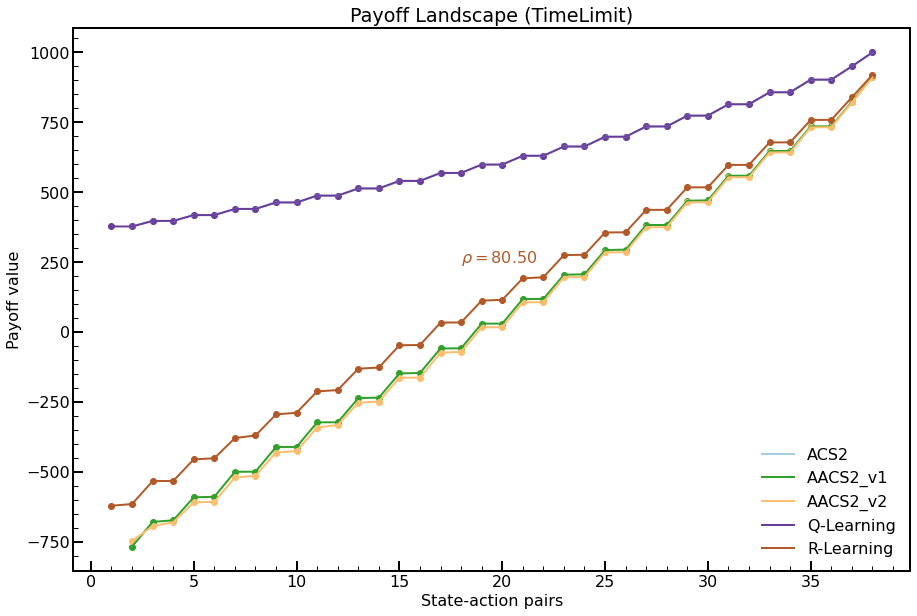

In [21]:
fig, ax = plt.subplots(figsize=(15, 10))

x = range(1, len(payoffs)+1)

for alg in ['ACS2', 'AACS2_v1', 'AACS2_v2', 'Q-Learning', 'R-Learning']:
    y = sorted([v[alg] for k, v in payoffs.items()])
    
    plt.scatter(x, y, color=COLORS[alg])
    plt.plot(x, y, label=alg,  linewidth=2, color=COLORS[alg])

# x-axis
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.set_major_formatter(FormatStrFormatter('%1.0f')) 
ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in')
ax.xaxis.set_tick_params(which='minor', size=5, width=1, direction='in')
ax.set_xlabel("State-action pairs")

# y-axis
ax.yaxis.set_major_locator(MultipleLocator(250))
ax.yaxis.set_minor_locator(MultipleLocator(50))
ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in')
ax.yaxis.set_tick_params(which='minor', size=5, width=1, direction='in')
ax.set_ylabel("Payoff value")

# others
ax.set_title(f"Payoff Landscape ({env.env.__class__.__name__})")
ax.text(18, 250, fr'$\rho={rho:.2f}$', color=COLORS['R-Learning'])
ax.legend(loc='lower right', bbox_to_anchor=(1, 0), frameon=False)

# save fig
# plt.savefig('plots/corridor-payofflandscape.pdf', transparent=False, bbox_inches='tight')

plt.show()